# Horizontal and vertical weighting of soil moisture observations

**For the time being, this notebook is a sandbox.** Step by step, we will migrate mature functions to the actual `cosmicsense` library.

The horizontal and vertical weighting equations used here originate from different references: Zreda et al. (2008), Franz et al. (2012), Bogena et al. (2013), Koehli et al. (2015), and Schroen et al. (2017).  Yet, the present implementation is only based on the overview and benchmark study by [Schroen et al. (2017)](https://www.hydrol-earth-syst-sci.net/21/5009/2017/).

In [2]:
# Standard packages
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import numpy as np
import pandas as pd
import inspect

In [3]:
import cosmicsense as cs

In [4]:
# Display figures inline
%matplotlib inline
# Display figures as interactive (requires kernel restart)
#%matplotlib

## Horizontal footprint and weighting

### Functions that are independent of environmental conditions

Horizontal weighting functions have been - implicitely or explicitely - presented by Zreda et al. (2008) and Bogena et al. (2013). Here are two implementations based on Schroen et al. (2017):

- [horizontal_weight_zreda2008a](../generated/cosmicsense.core.horizontal_weight_zreda2008a.html)
- [horizontal_weight_zreda2008b](../generated/cosmicsense.core.horizontal_weight_zreda2008b.html)

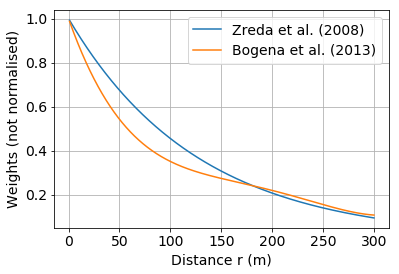

In [5]:
plt.rc('font', **{'size'   : 14})
r = np.arange(1, 300, 0.1)
plt.plot(r, cs.core.horizontal_weight_zreda2008a(r), label="Zreda et al. (2008)")
plt.plot(r, cs.core.horizontal_weight_zreda2008b(r), label="Bogena et al. (2013)")
plt.xlabel("Distance r (m)")
plt.ylabel("Weights (not normalised)")
plt.grid()
_ = plt.legend()

### Functions that depend of environmental conditions

Later, revised horizontal weighting functions have been proposed by Koehli et al. (2015), based on URANOS simulations. A large set of functions and parameters was presented in Appendix A of Schroen et al. (2017).

Based on these functions, the actual horizontal weighting function is defined, together with an approximation for average soil moisture and air humidity conditions:

- [horizontal_weight_koehli](../generated/cosmicsense.core.horizontal_weight_koehli.html)
- [horizontal_weight_koehli_approx](../generated/cosmicsense.core.horizontal_weight_koehli_approx.html)

### Comparison of different weighting functions and parameters

The upper panel of the following figure tries to mimic Figure 2 in Schroen et al. (2017)

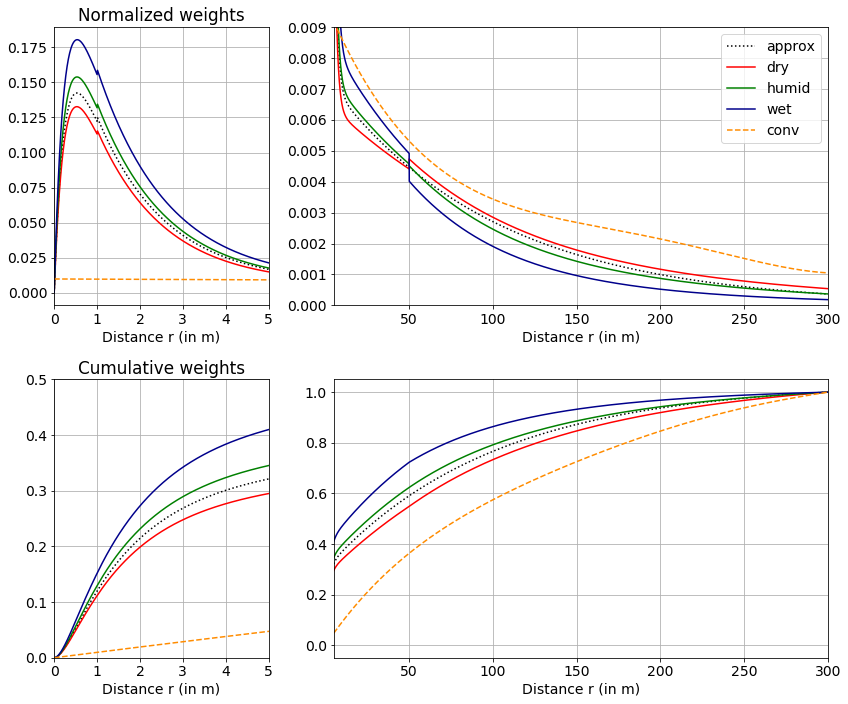

In [6]:
r = np.arange(0., 300, 0.01)
press = 1013.
Hveg = 0.

weights_approx = cs.core.horizontal_weight_koehli_approx(r)
weights_dry = cs.core.horizontal_weight_koehli(r, press=press, Hveg=Hveg, theta=0.1, h=5)
weights_humid = cs.core.horizontal_weight_koehli(r, press=press, Hveg=Hveg, theta=0.2, h=10)
weights_wet = cs.core.horizontal_weight_koehli(r, press=press, Hveg=Hveg, theta=0.4, h=15)
weights_zreda = cs.core.horizontal_weight_zreda2008b(r)

def normfunc(x):
    x = 100 * x / np.sum(x)
    return x
  
#normfunc = np.linalg.norm

weights_approx_norm = normfunc(weights_approx)
weights_dry_norm = normfunc(weights_dry)
weights_humid_norm = normfunc(weights_humid)
weights_wet_norm = normfunc(weights_wet)
weights_zreda_norm = normfunc(weights_zreda)

plt.rc('font', **{'size'   : 14})

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=1, rowspan=1)
plt.plot(r, weights_approx_norm, color="black", linestyle = "dotted", label="approx")
plt.plot(r, weights_dry_norm, color="red", label="dry")
plt.plot(r, weights_humid_norm, color="green", label="humid")
plt.plot(r, weights_wet_norm, color="darkblue", label="wet")
plt.plot(r, weights_zreda_norm, color="darkorange", ls = "dashed", label="conv")
plt.xlabel("Distance r (in m)")

ax1.set_xlim(0, 5)
#plt.ylim(0, 0.03)
ax1.grid()
ax1.set_title("Normalized weights")

#ax2 = plt.subplot(2,2,4)
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=2, rowspan=1)
plt.plot(r, weights_approx_norm, color="black", linestyle = "dotted", label="approx")
plt.plot(r, weights_dry_norm, color="red", label="dry")
plt.plot(r, weights_humid_norm, color="green", label="humid")
plt.plot(r, weights_wet_norm, color="darkblue", label="wet")
plt.plot(r, weights_zreda_norm, color="darkorange", ls = "dashed", label="conv")
plt.xlabel("Distance r (in m)")
plt.legend()
plt.xlim(5, 300)
plt.ylim(0, 0.009)
plt.grid()

def normfunc(x):
    x = np.cumsum(x)
    return x / np.max(x)
weights_approx_norm = normfunc(weights_approx)
weights_dry_norm = normfunc(weights_dry)
weights_humid_norm = normfunc(weights_humid)
weights_wet_norm = normfunc(weights_wet)
weights_zreda_norm = normfunc(weights_zreda)

ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=1)
plt.plot(r, weights_approx_norm, color="black", linestyle = "dotted", label="approx")
plt.plot(r, weights_dry_norm, color="red", label="dry")
plt.plot(r, weights_humid_norm, color="green", label="humid")
plt.plot(r, weights_wet_norm, color="darkblue", label="wet")
plt.plot(r, weights_zreda_norm, color="darkorange", ls = "dashed", label="conv")
plt.xlabel("Distance r (in m)")
plt.grid()
plt.xlim(0, 5)
plt.ylim(0, 0.5)
plt.title("Cumulative weights")

ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=2)
plt.plot(r, weights_approx_norm, color="black", linestyle = "dotted", label="approx")
plt.plot(r, weights_dry_norm, color="red", label="dry")
plt.plot(r, weights_humid_norm, color="green", label="humid")
plt.plot(r, weights_wet_norm, color="darkblue", label="wet")
plt.plot(r, weights_zreda_norm, color="darkorange", ls = "dashed", label="conv")
plt.xlabel("Distance r (in m)")
plt.grid()
plt.xlim(5, 300)


plt.tight_layout()

### Questions

- Are the discontinuities at 1 and 50 meters intended? They are also present in the R code provided in the Supplement of Schroen et al. (2017), but not in the paper itself.
- Which approach is recommended for normalisation of weights? Does it matter when different functions are compared?

Schroen et al. (2017) discuss, on page 5014, the effect of assumptions with regard to the horizontal and vertical representativeness of any point measurement of soil moisture to be used for calibration. The above functions account for the effect that the area of any "imaginary" ring around a CRNS probe increases with distance `r`, and that thus the contribution from such a ring, in terms of a simple areal proportion, increases. This is the reason why the weight decrease up to a distance of around 50 cm. The question is, however, whether we consider any measurements at distance `r` as representative for any soil moisture in that distance. If not, the effect of areal proportion should be removed from the weight so that $w = W_r / (2 * \pi * r)$. As a result, the weight of any point measurements close to the probe would increase dramatically.

/home/maik/miniconda3/envs/cosmic-sense/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/maik/miniconda3/envs/cosmic-sense/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


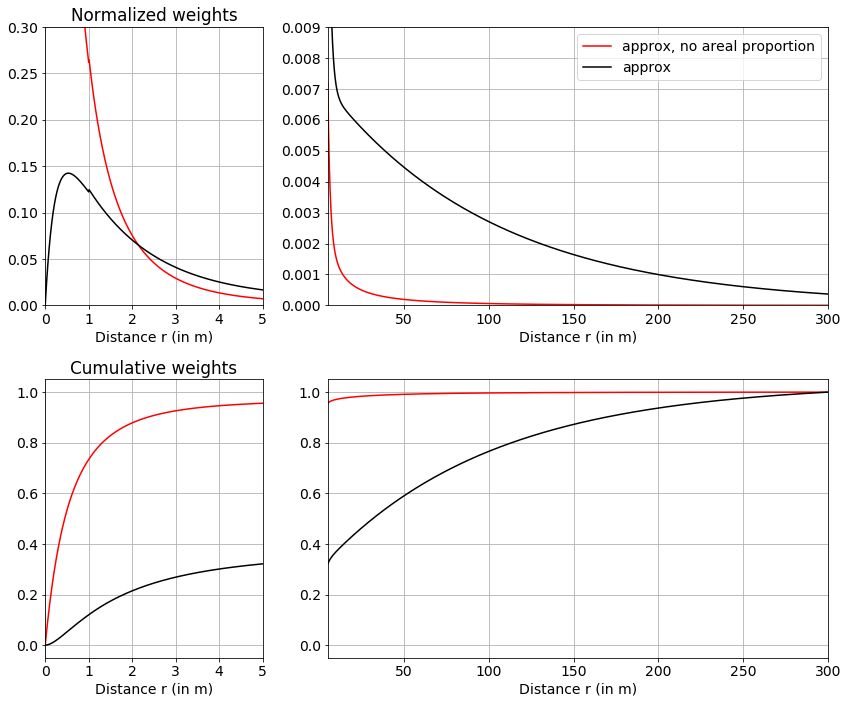

In [32]:
area_effect = (2 * np.pi * r)
weights_approx = cs.core.horizontal_weight_koehli_approx(r) / area_effect
weights_approx2 = cs.core.horizontal_weight_koehli_approx(r)

def normfunc(x):
    x = 100 * x / np.nansum(x)
    return x
  
#normfunc = np.linalg.norm

weights_approx_norm = normfunc(weights_approx)
weights_approx2_norm = normfunc(weights_approx2)

plt.rc('font', **{'size'   : 14})

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=1, rowspan=1)
plt.plot(r, weights_approx_norm, color="red", linestyle = "solid", label="approx, no areal proportion")
plt.plot(r, weights_approx2_norm, color="black", linestyle = "solid", label="approx")
plt.xlabel("Distance r (in m)")

ax1.set_xlim(0, 5)
plt.ylim(0, 0.3)
ax1.grid()
ax1.set_title("Normalized weights")

#ax2 = plt.subplot(2,2,4)
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=2, rowspan=1)
plt.plot(r, weights_approx_norm, color="red", linestyle = "solid", label="approx, no areal proportion")
plt.plot(r, weights_approx2_norm, color="black", linestyle = "solid", label="approx")
plt.xlabel("Distance r (in m)")
plt.legend()
plt.xlim(5, 300)
plt.ylim(0, 0.009)
plt.grid()

def normfunc(x):
    x = np.nancumsum(x)
    return x / np.nanmax(x)
weights_approx_norm = normfunc(weights_approx)
weights_approx2_norm = normfunc(weights_approx2)

ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=1)
plt.plot(r, weights_approx_norm, color="red", linestyle = "solid", label="approx, no areal proportion")
plt.plot(r, weights_approx2_norm, color="black", linestyle = "solid", label="approx2")
plt.xlabel("Distance r (in m)")
plt.grid()
plt.xlim(0, 5)
#plt.ylim(0, 0.5)
plt.title("Cumulative weights")

ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=2)
plt.plot(r, weights_approx_norm, color="red", linestyle = "solid", label="approx, no areal proportion")
plt.plot(r, weights_approx2_norm, color="black", linestyle = "solid", label="approx")
plt.xlabel("Distance r (in m)")
plt.grid()
plt.xlim(5, 300)


plt.tight_layout()

## Vertical footprint and weighting

Vertical weighting functions had been suggested by Franz et al. (2012), among others, in which the penetration depth depended on soil moisture, but not on the distance to the probe. Again, revised vertical weighting functions were presented by Koehli et al. (2015) and Schroen et al. (2017). These are based on URANOS simulations and take into account the decrease of penetration depth with distance to the probe.

- [penetration_depth_franz](../generated/cosmicsense.core.penetration_depth_franz.html)
- [D86](../generated/cosmicsense.core.D86.html)
- [vertical_weight_franz](../generated/cosmicsense.core.vertical_weight_franz.html)
- [vertical_weight_koehli](../generated/cosmicsense.core.vertical_weight_koehli.html)

In [8]:
press = 1013. # barometric pressure (in hPa)
Hveg = 0.
rhob = 1.4 # bulk density in kg/l
r = np.arange(0., 350, 50)
theta = np.arange(0.0, 0.6, 0.01)

# Penetration depths for combinations of distance and theta
D_koehli = cs.core.D86(r, theta, press, Hveg, rhob)
D_franz = cs.core.penetration_depth_franz(theta) * 100

# Normalised vertical weights
#depths = np.linspace(0, 30, 12)
depths = np.arange(0, 31, 1)
vweights = cs.core.vertical_weight_koehli(1, depths, 0.17, press, Hveg, rhob)
vweights = vweights / np.sum(vweights)
vweights_franz = cs.core.vertical_weight_franz(depths, 0.17)
vweights_franz = vweights_franz / np.sum(vweights_franz)

D86_dry = cs.core.D86(r, 0.1, press, Hveg, rhob)
D86_humid = cs.core.D86(r, 0.2, press, Hveg, rhob)
D86_wet = cs.core.D86(r, 0.4, press, Hveg, rhob)

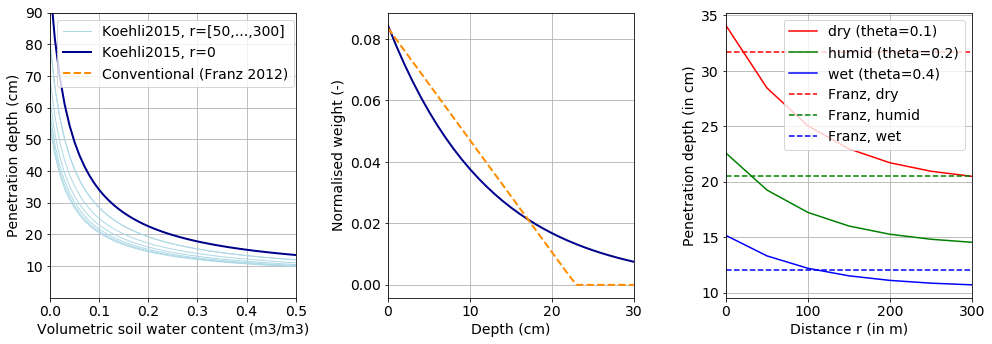

In [9]:
plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.plot(theta, D_koehli.T, color="lightblue", lw=1)
plt.plot(theta, D_koehli[1,:], color="lightblue", lw=1, label="Koehli2015, r=[50,...,300]")
plt.plot(theta, D_koehli[0,:], color="darkblue", lw=2, label="Koehli2015, r=0")
plt.plot(theta, D_franz, color="darkorange", ls="dashed", lw=2, label="Conventional (Franz 2012)")
plt.yticks(range(10,100,10))
plt.xlim(0,0.5)
plt.ylim(0,90)
plt.grid()
plt.xlabel("Volumetric soil water content (m3/m3)")
plt.ylabel("Penetration depth (cm)")
plt.legend()

plt.subplot(1,3,2)
plt.plot(depths, vweights, color="darkblue", lw=2)
plt.plot(depths, vweights_franz, color="darkorange", ls="dashed", lw=2)
plt.grid()
plt.xlim(0,30)
plt.xlabel("Depth (cm)")
plt.ylabel("Normalised weight (-)")


plt.subplot(1,3,3)#plt.subplot2grid((2, 3), (0, 0), colspan=1, rowspan=1)
plt.plot(r, D86_dry, color="red", label="dry (theta=0.1)")
plt.plot(r, D86_humid, color="green", label="humid (theta=0.2)")
plt.plot(r, D86_wet, color="blue", label="wet (theta=0.4)")
plt.axhline(cs.core.penetration_depth_franz(0.1), color="red", ls="dashed", label="Franz, dry")
plt.axhline(cs.core.penetration_depth_franz(0.2), color="green", ls="dashed", label="Franz, humid")
plt.axhline(cs.core.penetration_depth_franz(0.4), color="blue", ls="dashed",  label="Franz, wet")
plt.xlabel("Distance r (in m)")
plt.ylabel("Penetration depth (in cm)")
plt.legend()
plt.xlim(0,300)
plt.grid()

plt.tight_layout()

R-Code has been provided in [Schrön et al. (2017) Supplement](https://www.hydrol-earth-syst-sci.net/21/5009/2017/hess-21-5009-2017-supplement.zip).